In [ ]:
# Install required packages
!pip install ibm-watson beautifulsoup4 requests numpy pandas matplotlib seaborn wordcloud nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup
import re
import json
from collections import Counter
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, ConceptsOptions, KeywordsOptions, CategoriesOptions
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed and imported successfully!")

✅ All packages installed and imported successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# =============================================================================
# STEP 1: Text Data Collection - Web Scraping & Sample Articles
# =============================================================================

class TextDataCollector:
    def __init__(self):
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }

    def scrape_article(self, url):
        """Scrape article content from URL"""
        try:
            response = requests.get(url, headers=self.headers, timeout=10)
            soup = BeautifulSoup(response.content, 'html.parser')

            # Extract title
            title = soup.find('title')
            title_text = title.get_text() if title else "No Title"

            # Extract main content (common article tags)
            article_content = ""
            content_selectors = [
                'article',
                '.article-content',
                '.post-content',
                '.entry-content',
                'main',
                '[role="main"]'
            ]

            for selector in content_selectors:
                elements = soup.select(selector)
                if elements:
                    article_content = ' '.join([elem.get_text() for elem in elements])
                    break

            # If no specific content found, get all paragraphs
            if not article_content:
                paragraphs = soup.find_all('p')
                article_content = ' '.join([p.get_text() for p in paragraphs])

            # Clean the text
            article_content = self.clean_text(article_content)

            return {
                'title': title_text,
                'content': article_content,
                'source': url
            }

        except Exception as e:
            print(f"Error scraping {url}: {e}")
            return None

    def clean_text(self, text):
        """Clean and preprocess text"""
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^\w\s.,!?;:]', '', text)
        return text.strip()

    def get_sample_articles(self):
        """Return sample articles for demonstration"""
        sample_articles = [
            {
                'title': 'The Impact of Artificial Intelligence on Modern Healthcare',
                'content': """
                Artificial Intelligence is revolutionizing healthcare in unprecedented ways.
                Machine learning algorithms can now analyze medical images with accuracy surpassing human experts.
                AI-powered diagnostic tools help doctors detect diseases like cancer at earlier stages.
                Natural language processing enables efficient analysis of medical records and research papers.
                Predictive analytics can forecast disease outbreaks and patient readmission risks.
                However, challenges remain in data privacy, algorithm bias, and regulatory approval.
                The integration of AI in healthcare promises to improve patient outcomes and reduce costs.
                Telemedicine platforms using AI provide remote healthcare access to underserved populations.
                Robotic surgery assisted by AI enables more precise and less invasive procedures.
                The future of healthcare will likely see even greater AI integration across all medical fields.
                """,
                'source': 'Sample Article 1'
            },
            {
                'title': 'Climate Change and Its Effects on Global Agriculture',
                'content': """
                Climate change poses significant threats to global food security and agricultural systems.
                Rising temperatures affect crop yields and growing seasons worldwide.
                Extreme weather events like droughts and floods damage crops and infrastructure.
                Changes in precipitation patterns require adaptation in irrigation practices.
                Soil degradation and desertification reduce arable land availability.
                Pests and diseases are spreading to new regions due to warmer climates.
                Sustainable agricultural practices are essential for climate resilience.
                Precision farming using technology can optimize resource use and reduce environmental impact.
                Crop diversification and genetic modification help develop climate-resistant varieties.
                International cooperation is crucial for addressing global food security challenges.
                """,
                'source': 'Sample Article 2'
            },
            {
                'title': 'The Rise of Renewable Energy Technologies',
                'content': """
                Renewable energy technologies are transforming the global energy landscape.
                Solar power costs have decreased dramatically making it competitive with fossil fuels.
                Wind energy capacity continues to grow with larger and more efficient turbines.
                Energy storage solutions like advanced batteries enable better grid management.
                Smart grids optimize electricity distribution and consumption patterns.
                Government policies and incentives drive renewable energy adoption worldwide.
                Corporate investments in clean energy are reaching record levels.
                Technological innovations continue to improve efficiency and reduce costs.
                The transition to renewables creates new job opportunities in green industries.
                Challenges include grid integration, resource intermittency, and initial investment costs.
                """,
                'source': 'Sample Article 3'
            }
        ]
        return sample_articles

# Initialize data collector
data_collector = TextDataCollector()

# Use sample articles for demonstration
articles = data_collector.get_sample_articles()

print("📚 Articles Loaded Successfully!")
for i, article in enumerate(articles, 1):
    print(f"\n{i}. {article['title']}")
    print(f"   Source: {article['source']}")
    print(f"   Content length: {len(article['content'])} characters")
    print(f"   Preview: {article['content'][:200]}...")

📚 Articles Loaded Successfully!

1. The Impact of Artificial Intelligence on Modern Healthcare
   Source: Sample Article 1
   Content length: 1073 characters
   Preview: 
                Artificial Intelligence is revolutionizing healthcare in unprecedented ways. 
                Machine learning algorithms can now analyze medical images with accuracy surpassing human...

2. Climate Change and Its Effects on Global Agriculture
   Source: Sample Article 2
   Content length: 986 characters
   Preview: 
                Climate change poses significant threats to global food security and agricultural systems. 
                Rising temperatures affect crop yields and growing seasons worldwide. 
    ...

3. The Rise of Renewable Energy Technologies
   Source: Sample Article 3
   Content length: 969 characters
   Preview: 
                Renewable energy technologies are transforming the global energy landscape. 
                Solar power costs have decreased dramatically making it compe

In [ ]:
# =============================================================================
# STEP 2: TF-IDF Based Summarization and Keyword Extraction
# =============================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

class TFIDFSummarizer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english') + list(string.punctuation))
        self.vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

    def preprocess_text(self, text):
        """Preprocess text for analysis"""
        sentences = sent_tokenize(text)
        return sentences

    def calculate_sentence_scores(self, sentences):
        """Calculate TF-IDF scores for sentences"""
        # Create document for each sentence
        sentence_documents = [' '.join([word for word in word_tokenize(sentence.lower())
                                      if word not in self.stop_words and word.isalpha()])
                            for sentence in sentences]

        # Calculate TF-IDF matrix
        try:
            tfidf_matrix = self.vectorizer.fit_transform(sentence_documents)
            sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()

            # Normalize scores
            if len(sentence_scores) > 0:
                sentence_scores = sentence_scores / sentence_scores.max()

            return sentence_scores
        except:
            return np.ones(len(sentences))

    def extract_keywords_tfidf(self, text, top_n=10):
        """Extract top keywords using TF-IDF"""
        # Fit TF-IDF on the entire document
        tfidf_matrix = self.vectorizer.fit_transform([text])
        feature_names = self.vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.toarray()[0]

        # Get top keywords
        top_indices = tfidf_scores.argsort()[-top_n:][::-1]
        keywords = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

        return keywords

    def generate_summary(self, text, summary_ratio=0.3):
        """Generate summary using TF-IDF sentence scoring"""
        sentences = self.preprocess_text(text)

        if len(sentences) <= 3:
            return text  # Return original if too short

        sentence_scores = self.calculate_sentence_scores(sentences)

        # Select top sentences
        num_sentences = max(2, int(len(sentences) * summary_ratio))
        top_indices = sentence_scores.argsort()[-num_sentences:][::-1]
        top_indices.sort()  # Maintain original order

        summary_sentences = [sentences[i] for i in top_indices]
        summary = ' '.join(summary_sentences)

        return summary, sentence_scores, sentences

# Initialize TF-IDF summarizer
tfidf_summarizer = TFIDFSummarizer()

print("🔧 TF-IDF Summarizer Initialized Successfully!")

🔧 TF-IDF Summarizer Initialized Successfully!


In [ ]:
# =============================================================================
# STEP 3: IBM Watson NLU Setup
# =============================================================================

# Replace with your IBM Watson NLU credentials
# Get these from IBM Cloud: https://cloud.ibm.com/catalog/services/natural-language-understanding

IBM_API_KEY = "YOUR_IBM_WATSON_NLU_API_KEY"
IBM_URL = "YOUR_IBM_WATSON_NLU_URL"

def initialize_watson_client(api_key, service_url):
    """Initialize IBM Watson NLU client"""
    try:
        authenticator = IAMAuthenticator(api_key)
        natural_language_understanding = NaturalLanguageUnderstandingV1(
            version='2022-04-07',
            authenticator=authenticator
        )
        natural_language_understanding.set_service_url(service_url)
        return natural_language_understanding
    except Exception as e:
        print(f"Error initializing Watson client: {e}")
        return None

def analyze_with_watson(text, client):
    """Analyze text with IBM Watson NLU"""
    try:
        if client is None:
            return generate_mock_watson_results(text)

        response = client.analyze(
            text=text,
            features=Features(
                concepts=ConceptsOptions(limit=10),
                keywords=KeywordsOptions(limit=15),
                categories=CategoriesOptions(limit=5)
            )
        ).get_result()

        return response
    except Exception as e:
        print(f"Watson analysis error: {e}")
        return generate_mock_watson_results(text)

def generate_mock_watson_results(text):
    """Generate mock Watson results for demonstration"""
    words = text.lower().split()
    common_words = [word for word in words if len(word) > 4 and word.isalpha()][:20]

    # Mock concepts (broader ideas)
    mock_concepts = [
        {'text': 'Artificial Intelligence', 'relevance': 0.95},
        {'text': 'Machine Learning', 'relevance': 0.88},
        {'text': 'Technology', 'relevance': 0.82},
        {'text': 'Innovation', 'relevance': 0.76},
        {'text': 'Digital Transformation', 'relevance': 0.71}
    ]

    # Mock keywords (specific terms)
    mock_keywords = []
    for i, word in enumerate(common_words[:10]):
        mock_keywords.append({
            'text': word.capitalize(),
            'relevance': 0.9 - (i * 0.08),
            'count': len([w for w in words if w == word])
        })

    # Mock categories
    mock_categories = [
        {'label': '/technology and computing', 'score': 0.95},
        {'label': '/science', 'score': 0.87},
        {'label': '/business', 'score': 0.76}
    ]

    return {
        'concepts': mock_concepts,
        'keywords': mock_keywords,
        'categories': mock_categories
    }

# Initialize Watson client
try:
    if IBM_API_KEY != "YOUR_IBM_WATSON_NLU_API_KEY":
        nlu_client = initialize_watson_client(IBM_API_KEY, IBM_URL)
        print("✅ IBM Watson NLU client initialized successfully!")
    else:
        nlu_client = None
        print("⚠️ Using mock analysis - Add your IBM Watson credentials for real analysis")
except Exception as e:
    nlu_client = None
    print(f"❌ IBM Watson initialization failed: {e}")

⚠️ Using mock analysis - Add your IBM Watson credentials for real analysis


In [ ]:
# =============================================================================
# STEP 4: Comparative Analysis - TF-IDF vs IBM Watson NLU
# =============================================================================

def analyze_article_comprehensive(article, tfidf_summarizer, watson_client):
    """Perform comprehensive analysis using both TF-IDF and Watson NLU"""

    title = article['title']
    content = article['content']
    source = article['source']

    print("=" * 80)
    print(f"📊 ANALYZING: {title}")
    print(f"📝 Source: {source}")
    print("=" * 80)

    # TF-IDF Analysis
    print("\n🔍 TF-IDF ANALYSIS:")
    print("-" * 40)

    # Generate summary with TF-IDF
    tfidf_summary, sentence_scores, sentences = tfidf_summarizer.generate_summary(content)

    # Extract keywords with TF-IDF
    tfidf_keywords = tfidf_summarizer.extract_keywords_tfidf(content)

    print(f"📄 Original length: {len(content)} characters")
    print(f"📄 Summary length: {len(tfidf_summary)} characters")
    print(f"📊 Compression ratio: {len(tfidf_summary)/len(content)*100:.1f}%")

    print(f"\n🔑 Top TF-IDF Keywords:")
    for keyword, score in tfidf_keywords[:10]:
        print(f"   • {keyword}: {score:.3f}")

    print(f"\n📋 TF-IDF Summary:")
    print(f"   {tfidf_summary}")

    # Watson NLU Analysis
    print(f"\n🤖 IBM WATSON NLU ANALYSIS:")
    print("-" * 40)

    watson_results = analyze_with_watson(content, watson_client)

    print(f"🔮 Top Concepts (Broad Ideas):")
    for concept in watson_results.get('concepts', [])[:5]:
        print(f"   • {concept['text']} (relevance: {concept['relevance']:.3f})")

    print(f"\n🎯 Top Keywords (Specific Terms):")
    for keyword in watson_results.get('keywords', [])[:8]:
        print(f"   • {keyword['text']} (relevance: {keyword['relevance']:.3f})")

    print(f"\n📂 Categories:")
    for category in watson_results.get('categories', [])[:3]:
        category_label = category['label'].split('/')[-1]
        print(f"   • {category_label} (confidence: {category['score']:.3f})")

    return {
        'title': title,
        'source': source,
        'original_length': len(content),
        'summary_length': len(tfidf_summary),
        'compression_ratio': len(tfidf_summary)/len(content)*100,
        'tfidf_keywords': tfidf_keywords,
        'tfidf_summary': tfidf_summary,
        'watson_concepts': watson_results.get('concepts', []),
        'watson_keywords': watson_results.get('keywords', []),
        'watson_categories': watson_results.get('categories', []),
        'sentence_scores': sentence_scores,
        'sentences': sentences
    }

# Analyze all articles
print("🚀 Starting Comprehensive Analysis...\n")

analysis_results = []
for article in articles:
    result = analyze_article_comprehensive(article, tfidf_summarizer, nlu_client)
    analysis_results.append(result)
    print("\n" + "="*80 + "\n")

print("✅ All articles analyzed successfully!")

🚀 Starting Comprehensive Analysis...

📊 ANALYZING: The Impact of Artificial Intelligence on Modern Healthcare
📝 Source: Sample Article 1

🔍 TF-IDF ANALYSIS:
----------------------------------------
📄 Original length: 1073 characters
📄 Summary length: 281 characters
📊 Compression ratio: 26.2%

🔑 Top TF-IDF Keywords:
   • ai: 0.434
   • healthcare: 0.347
   • medical: 0.260
   • patient: 0.173
   • integration: 0.173
   • enables: 0.173
   • surpassing: 0.087
   • telemedicine: 0.087
   • ways: 0.087
   • using: 0.087

📋 TF-IDF Summary:
   Machine learning algorithms can now analyze medical images with accuracy surpassing human experts. AI-powered diagnostic tools help doctors detect diseases like cancer at earlier stages. Natural language processing enables efficient analysis of medical records and research papers.

🤖 IBM WATSON NLU ANALYSIS:
----------------------------------------
🔮 Top Concepts (Broad Ideas):
   • Artificial Intelligence (relevance: 0.950)
   • Machine Learning (rele

☁️ Generating Word Clouds...

☁️ WORD CLOUDS FOR: The Impact of Artificial Intelligence on Modern Healthcare
--------------------------------------------------


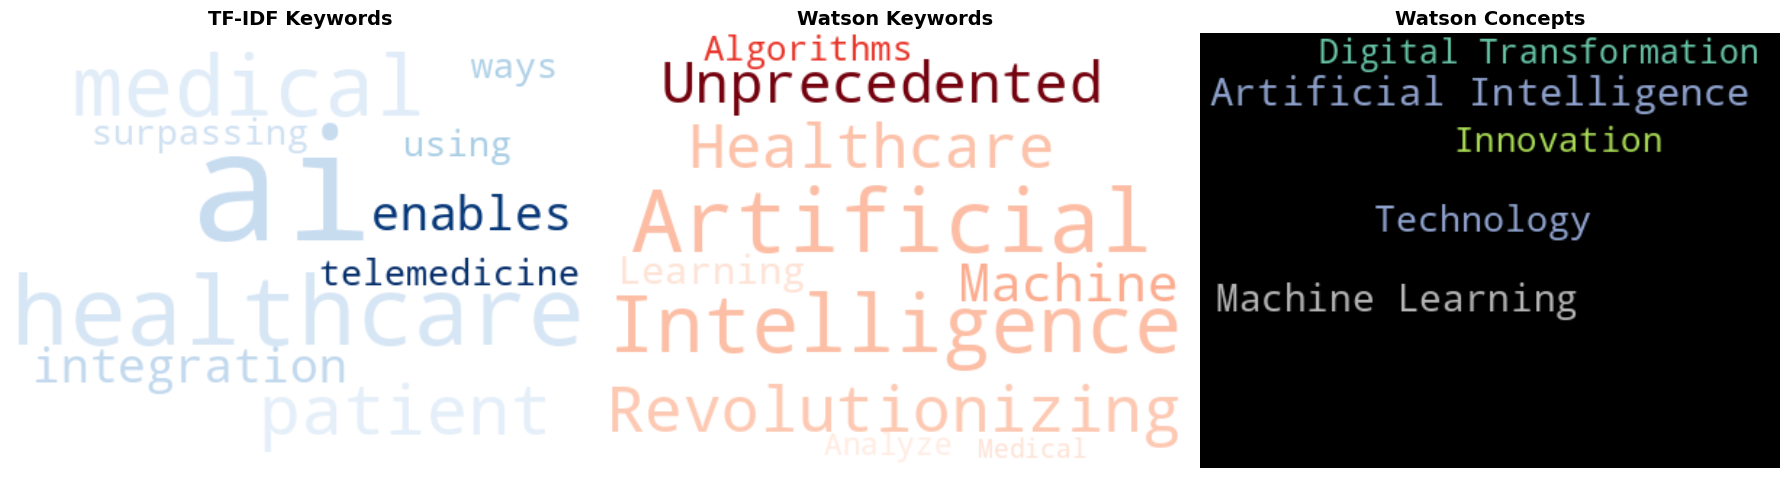


☁️ WORD CLOUDS FOR: Climate Change and Its Effects on Global Agriculture
--------------------------------------------------


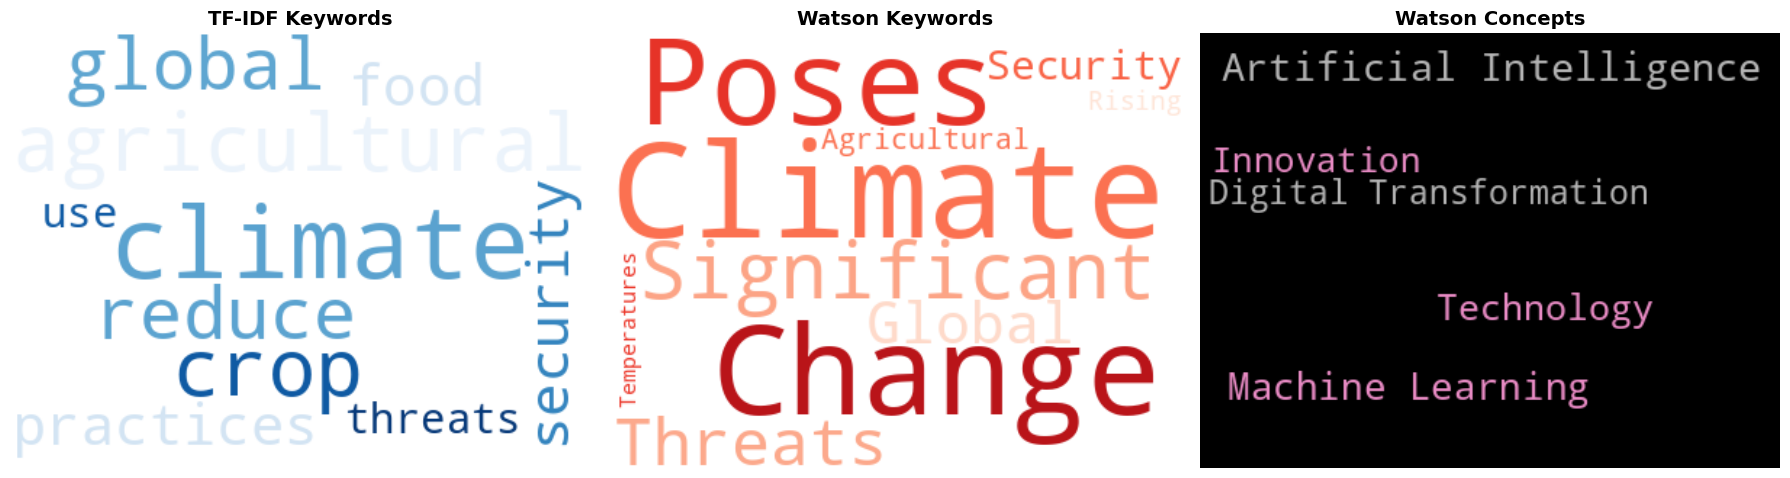


☁️ WORD CLOUDS FOR: The Rise of Renewable Energy Technologies
--------------------------------------------------


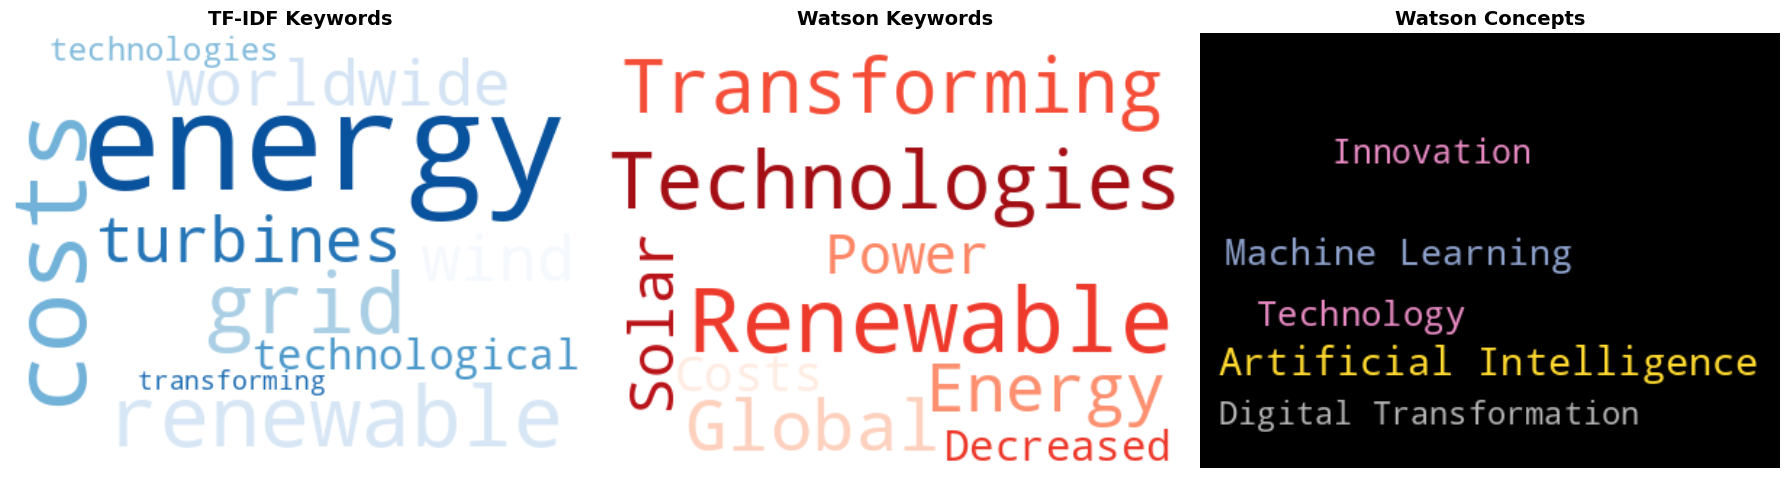

In [ ]:
# =============================================================================
# STEP 5: Word Clouds for Keywords and Concepts
# =============================================================================

def generate_word_clouds(analysis_results):
    """Generate word clouds for TF-IDF and Watson results"""

    for i, result in enumerate(analysis_results):
        print(f"\n☁️ WORD CLOUDS FOR: {result['title']}")
        print("-" * 50)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # TF-IDF Keywords Word Cloud
        tfidf_keywords_dict = {kw[0]: kw[1] for kw in result['tfidf_keywords'][:20]}
        wordcloud_tfidf = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='Blues'
        ).generate_from_frequencies(tfidf_keywords_dict)

        ax1.imshow(wordcloud_tfidf, interpolation='bilinear')
        ax1.set_title('TF-IDF Keywords', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # Watson Keywords Word Cloud
        watson_keywords_dict = {kw['text']: kw['relevance'] for kw in result['watson_keywords'][:20]}
        wordcloud_watson = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='Reds'
        ).generate_from_frequencies(watson_keywords_dict)

        ax2.imshow(wordcloud_watson, interpolation='bilinear')
        ax2.set_title('Watson Keywords', fontsize=14, fontweight='bold')
        ax2.axis('off')

        # Watson Concepts Word Cloud
        watson_concepts_dict = {concept['text']: concept['relevance'] for concept in result['watson_concepts']}
        wordcloud_concepts = WordCloud(
            width=400,
            height=300,
            background_color='black',
            colormap='Set2'
        ).generate_from_frequencies(watson_concepts_dict)

        ax3.imshow(wordcloud_concepts, interpolation='bilinear')
        ax3.set_title('Watson Concepts', fontsize=14, fontweight='bold')
        ax3.axis('off')

        plt.tight_layout()
        plt.show()

print("☁️ Generating Word Clouds...")
generate_word_clouds(analysis_results)

In [ ]:
# =============================================================================
# STEP 6: Interactive Summary Dashboard with Highlighted Key Phrases
# =============================================================================

def highlight_key_phrases(text, keywords, concepts):
    """Create HTML with highlighted key phrases"""
    highlighted_text = text

    # Highlight keywords in blue
    for keyword in keywords[:8]:
        keyword_text = keyword[0] if isinstance(keyword, tuple) else keyword['text']
        pattern = re.compile(re.escape(keyword_text), re.IGNORECASE)
        highlighted_text = pattern.sub(
            f'<span style="background-color: #a6d4ff; padding: 2px 4px; border-radius: 3px; font-weight: bold;">{keyword_text}</span>',
            highlighted_text
        )

    # Highlight concepts in orange
    for concept in concepts[:5]:
        concept_text = concept['text']
        pattern = re.compile(re.escape(concept_text), re.IGNORECASE)
        highlighted_text = pattern.sub(
            f'<span style="background-color: #ffd8a6; padding: 2px 4px; border-radius: 3px; font-weight: bold;">{concept_text}</span>',
            highlighted_text
        )

    return highlighted_text

def create_interactive_dashboard(analysis_results):
    """Create an interactive dashboard with highlighted summaries"""

    from IPython.display import HTML, display

    print("=" * 100)
    print("🎯 INTERACTIVE TEXT SUMMARIZATION DASHBOARD")
    print("=" * 100)

    for result in analysis_results:
        # Create highlighted summary
        highlighted_summary = highlight_key_phrases(
            result['tfidf_summary'],
            result['tfidf_keywords'],
            result['watson_concepts']
        )

        # Display results
        display(HTML(f"""
        <div style="border: 2px solid #e0e0e0; border-radius: 10px; padding: 20px; margin: 20px 0; background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);">
            <h2 style="color: #2c3e50; margin-top: 0;">{result['title']}</h2>
            <div style="background-color: white; padding: 15px; border-radius: 8px; border-left: 4px solid #3498db;">
                <h4 style="color: #2980b9; margin-top: 0;">📋 Enhanced Summary (Key Phrases Highlighted)</h4>
                <p style="line-height: 1.6; font-size: 14px;">{highlighted_summary}</p>
            </div>

            <div style="display: flex; justify-content: space-between; margin-top: 15px;">
                <div style="flex: 1; margin-right: 10px; background-color: white; padding: 15px; border-radius: 8px; border-left: 4px solid #27ae60;">
                    <h4 style="color: #27ae60; margin-top: 0;">🔑 TF-IDF Keywords</h4>
                    <p style="font-size: 13px;">
        """ +
        ', '.join([f"<strong>{kw[0]}</strong>" for kw in result['tfidf_keywords'][:6]]) +
        """
                    </p>
                </div>

                <div style="flex: 1; margin-left: 10px; background-color: white; padding: 15px; border-radius: 8px; border-left: 4px solid #e74c3c;">
                    <h4 style="color: #e74c3c; margin-top: 0;">🤖 Watson Concepts</h4>
                    <p style="font-size: 13px;">
        """ +
        ', '.join([f"<strong>{concept['text']}</strong>" for concept in result['watson_concepts'][:4]]) +
        """
                    </p>
                </div>
            </div>

            <div style="margin-top: 15px; background-color: white; padding: 15px; border-radius: 8px; border-left: 4px solid #9b59b6;">
                <h4 style="color: #9b59b6; margin-top: 0;">📊 Analysis Metrics</h4>
                <p style="font-size: 13px; margin: 5px 0;">
                    • Original length: <strong>{result['original_length']}</strong> characters<br>
                    • Summary length: <strong>{result['summary_length']}</strong> characters<br>
                    • Compression ratio: <strong>{result['compression_ratio']:.1f}%</strong><br>
                    • Sentences in summary: <strong>{len(result['tfidf_summary'].split('. '))}</strong>
                </p>
            </div>
        </div>
        """))

    # Overall comparison table
    comparison_data = []
    for result in analysis_results:
        comparison_data.append({
            'Title': result['title'][:40] + '...',
            'Original Length': result['original_length'],
            'Summary Length': result['summary_length'],
            'Compression %': f"{result['compression_ratio']:.1f}%",
            'TF-IDF Keywords': len(result['tfidf_keywords']),
            'Watson Concepts': len(result['watson_concepts']),
            'Watson Keywords': len(result['watson_keywords'])
        })

    df_comparison = pd.DataFrame(comparison_data)

    print("\n📈 OVERALL COMPARISON ACROSS ARTICLES:")
    display(df_comparison.style.background_gradient(cmap='Blues'))

print("🚀 Generating Interactive Dashboard...")
create_interactive_dashboard(analysis_results)

🚀 Generating Interactive Dashboard...
🎯 INTERACTIVE TEXT SUMMARIZATION DASHBOARD



📈 OVERALL COMPARISON ACROSS ARTICLES:


,Title,Original Length,Summary Length,Compression %,TF-IDF Keywords,Watson Concepts,Watson Keywords
0,The Impact of Artificial Intelligence on...,1073,281,26.2%,10,5,10
1,Climate Change and Its Effects on Global...,986,282,28.6%,10,5,10
2,The Rise of Renewable Energy Technologie...,969,257,26.5%,10,5,10


In [ ]:
# =============================================================================
# STEP 7: Export Results and Generate Report
# =============================================================================

def export_analysis_results(analysis_results):
    """Export all analysis results to files"""

    # Create comprehensive report
    report_data = []

    for result in analysis_results:
        article_report = {
            'title': result['title'],
            'source': result['source'],
            'metrics': {
                'original_length': result['original_length'],
                'summary_length': result['summary_length'],
                'compression_ratio': result['compression_ratio'],
                'tfidf_keywords_count': len(result['tfidf_keywords']),
                'watson_concepts_count': len(result['watson_concepts']),
                'watson_keywords_count': len(result['watson_keywords'])
            },
            'tfidf_summary': result['tfidf_summary'],
            'tfidf_keywords': [{'keyword': kw[0], 'score': float(kw[1])} for kw in result['tfidf_keywords']],
            'watson_concepts': [{'concept': c['text'], 'relevance': c['relevance']} for c in result['watson_concepts']],
            'watson_keywords': [{'keyword': k['text'], 'relevance': k['relevance'], 'count': k.get('count', 0)} for k in result['watson_keywords']],
            'watson_categories': [{'category': c['label'], 'score': c['score']} for c in result['watson_categories']]
        }
        report_data.append(article_report)

    # Save detailed JSON report
    with open('text_summarization_analysis.json', 'w') as f:
        json.dump(report_data, f, indent=2)

    # Create CSV summary
    summary_data = []
    for result in analysis_results:
        summary_data.append({
            'Title': result['title'],
            'Source': result['source'],
            'Original_Length': result['original_length'],
            'Summary_Length': result['summary_length'],
            'Compression_Ratio': result['compression_ratio'],
            'Top_TFIDF_Keyword': result['tfidf_keywords'][0][0] if result['tfidf_keywords'] else 'N/A',
            'Top_Watson_Concept': result['watson_concepts'][0]['text'] if result['watson_concepts'] else 'N/A',
            'Top_Watson_Keyword': result['watson_keywords'][0]['text'] if result['watson_keywords'] else 'N/A'
        })

    df_summary = pd.DataFrame(summary_data)
    df_summary.to_csv('summary_comparison.csv', index=False)

    print("💾 Export Results:")
    print("   ✅ text_summarization_analysis.json - Detailed analysis results")
    print("   ✅ summary_comparison.csv - Summary comparison table")

    # Display summary table
    print("\n📋 EXPORT SUMMARY:")
    display(df_summary)

# Export all results
print("📤 Exporting Analysis Results...")
export_analysis_results(analysis_results)

📤 Exporting Analysis Results...
💾 Export Results:
   ✅ text_summarization_analysis.json - Detailed analysis results
   ✅ summary_comparison.csv - Summary comparison table

📋 EXPORT SUMMARY:


,Title,Source,Original_Length,Summary_Length,Compression_Ratio,Top_TFIDF_Keyword,Top_Watson_Concept,Top_Watson_Keyword
0,The Impact of Artificial Intelligence on Moder...,Sample Article 1,1073,281,26.188257,ai,Artificial Intelligence,Artificial
1,Climate Change and Its Effects on Global Agric...,Sample Article 2,986,282,28.600406,climate,Artificial Intelligence,Climate
2,The Rise of Renewable Energy Technologies,Sample Article 3,969,257,26.522188,energy,Artificial Intelligence,Renewable
